## Coding Discussion 04 - Week 10
### 1 November 2020
#### Kryslette Bunyi

# Instructions

For this coding discussion, let's play around with some of the linear algebra concepts that we've covered in class. Specifically, let's return to our discussion of representing text as vectors and analyzing the angle between those vectors (which as we saw, offers a measure of similarity).

In the `Data/` folder, there are five separate news reports on Turkish President Erdogan addressing the murder of journalist Jamal Khashoggi in `.txt` files. Each contains the same story (relatively speaking) from different sources with different political leanings/interests. In addition to this, I also include `stop-words.csv` file containing common English words that we want to purge from our text (recall there are words that are common to all sentences, like "the" and "and", that we want to remove when comparing documents).

Use what we know about (a) reading in text files, (b) data manipulation, and (c) linear algebra to analyze the difference between these documents. Does each news site report on these stories in a similar way? Which news sites talk about the Khashoggi scandal in similar/dissimilar ways? If you change what words you remove, does the picture of similarity change?

This discussion is largely open. Probe the data however you see fit. The only restriction is that you must calculate the cosine similarity on your own. Don't rely on any canned functions that do this for you.

In [1]:
# Load needed package/s
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#nltk.download("stopwords")
from nltk.corpus import stopwords as sw

In [2]:
def importnews():
    """This is a function that imports news articles saved in .txt format from the current working directory.

    Arg:
        None

    Returns (Prints):
        articles: DataFrame that contains the name of the news outlet and the content of the text file.

    """
    # List files in working directory
    files = os.listdir()
    
    # Initialize lists
    NewsSite = []
    Content=[]
    
    # Iterate through txt files and append text to data frame
    for file in files:
        i = 0
        if file[-3:] == "txt":
            i = i + 1
            with open(file,mode="r",encoding='utf-8') as article:
                # Read in the data
                NewsSite.append(file[:-14])
                Content.append(article.read())
    articles = pd.DataFrame(Content,index=NewsSite,columns=["Content"])
    return articles

In [3]:
articles = importnews()
articles

,Content
aljazeera,"Turkey, Istanbul - Turkish President Recep Tay..."
bbc,Recep Tayyip Erdogan says many questions need ...
breitbart,U.S. President Donald Trump and Turkish Presid...
cnn,"Istanbul, Turkey (CNN) Jamal Khashoggi died as..."
fox,Saudi officials planned the savage murder of S...


In [4]:
# Read in stopwords
stopwords = pd.read_csv("stop_words.csv")
stopwords = list(stopwords["word"])

In [5]:
def tokenize(text=None,stopwords=None):
    """This is a function that standardizes and parses a string's component words in preparation 
    for text similarity analysis, removing stopwords.

    Arg:
        text: string that contains the text to be split
        stopwords: list that contains the words to be excluded from the analysis

    Returns (Prints):
        text_list2: list that contains the input string's standardized words, excluding stopwords

    """
    text = text.lower()
    text = text.replace('.','')
    text = text.replace('“','')
    text = text.replace('”','')
    text = text.replace("’","'")
    text = text.replace('"','')
    text = text.replace(',','')
    text = text.replace('?','')
    text = text.replace('[','')
    text = text.replace(']','')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace("!",'')
    text_list = text.split()
    text_list2 = [word for word in text_list if word not in stopwords]
    return text_list2

In [6]:
def convert_text_to_dtm(txt,stopwords=None):
    """This converts text into a document term matrix.

    Arg:
        txt: string that contains the text to be split
        stopwords: list that contains the words to be excluded from the analysis

    Returns (Prints):
        d: DataFrame that contains the input string's unique words and their frequency (excluding stopwords)

    """
    d = dict()
    for word in tokenize(txt,stopwords):
        if word in d:
            d[word][0] += 1
        else:
            d[word] = [1]
    return pd.DataFrame(d)

In [7]:
def gen_DTM(texts,stopwords=None):
    """This converts a list of texts into a document term matrix.

    Arg:
        texts: list of strings that contain the text to be split
        stopwords: list that contains the words to be excluded from the analysis

    Returns (Prints):
        DTM: DataFrame that contains the unique words and their frequency (excluding stopwords) for each text in the list

    """
    DTM = pd.DataFrame()
    for text in texts:
        entry = convert_text_to_dtm(text,stopwords)
        DTM = DTM.append(pd.DataFrame(entry),ignore_index=True,sort=True) # Row bind
    
    DTM.fillna(0, inplace=True) # Fill in any missing values with 0s (i.e. when a word is in one text but not another)
    return DTM       

In [8]:
# Generate document term matrix
dtm = gen_DTM([article for article in articles["Content"]],stopwords) 
dtm.index = articles.index
dtm

,$50bn,'where,-,1,11,12,15,15-member,18,1:08,...,widely,withheld,woods,world,worse,writer,yalova,yelova,£385bn,—
aljazeera,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bbc,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
breitbart,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
cnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
fox,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,3.0


In [9]:
def cosine(a,b):
    """This computes for the cosine similarity between two vectors.

    Arg:
        a, b: vectors to be compared
        
    Returns (Prints):
        cos: number that represents the cosine similarity between the input vectors

    """
    #cos = np.dot(a,b)/(np.sqrt(np.dot(a,a)) * np.sqrt(np.dot(b,b))  )
    a_norm = 1/np.sqrt(np.dot(a,a))*a
    b_norm = 1/np.sqrt(np.dot(b,b))*b
    cos = np.dot(a_norm,b_norm)
    return cos

In [10]:
def csm(texts):
    """This generates a cosine similarity matrix for a given document term matrix.

    Arg:
        texts: DataFrame representing a document term matrix
        
    Returns (Prints):
        csmdf: DataFrame displaying the cosine similarity score of each row-column pair

    """
    # Initialize data frame
    csmdf = pd.DataFrame(index=texts.index,columns=texts.index)
    
    for index1, row1 in texts.iterrows():
        for index2, row2 in texts.iterrows():
            csmdf.loc[index1,index2] = round(cosine(row1,row2),4)
            
    return csmdf.astype("float")

In [11]:
# Generate cosine similarity matrix
csmdf = csm(dtm)
csmdf

,aljazeera,bbc,breitbart,cnn,fox
aljazeera,1.0000,0.6766,0.5990,0.5321,0.6929
bbc,0.6766,1.0000,0.5943,0.5038,0.6391
breitbart,0.5990,0.5943,1.0000,0.3779,0.5529
cnn,0.5321,0.5038,0.3779,1.0000,0.5331
fox,0.6929,0.6391,0.5529,0.5331,1.0000


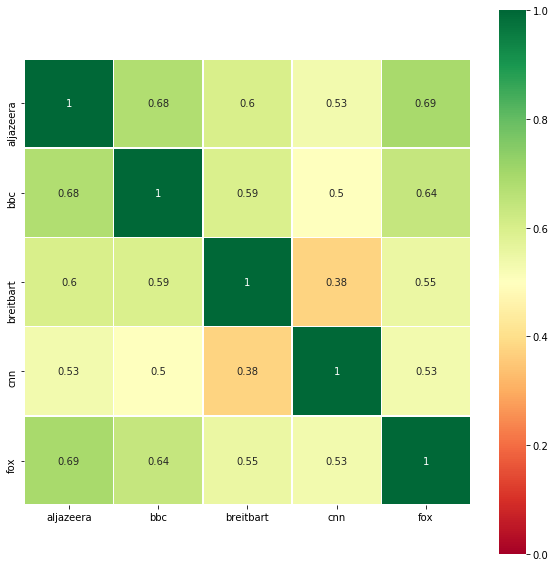

In [12]:
# Plot heatmap
plt.figure(figsize = (10,10))
sns.heatmap(csmdf,cmap="RdYlGn",vmin=0,vmax=1,linewidths=.5,annot=True,square=True)
plt.show()

In [13]:
# Reshape cosine similarity scores from wide to long
csmdf_sorted=csmdf.reset_index().melt(id_vars="index",var_name='news_site', value_name='cosine_similarity')
csmdf_sorted=csmdf_sorted.sort_values(by="cosine_similarity").drop_duplicates(subset="cosine_similarity")
csmdf_sorted=csmdf_sorted[csmdf_sorted["cosine_similarity"] != 1]
csmdf_sorted

,index,news_site,cosine_similarity
17,breitbart,cnn,0.3779
16,bbc,cnn,0.5038
15,aljazeera,cnn,0.5321
19,fox,cnn,0.5331
22,breitbart,fox,0.5529
7,breitbart,bbc,0.5943
2,breitbart,aljazeera,0.5990
21,bbc,fox,0.6391
5,aljazeera,bbc,0.6766
20,aljazeera,fox,0.6929


The news sites generally showed a moderate level of similarity in reporting Turkish President Erdogan's statements on the murder of journalist Jamal Khashoggi, as most registered cosine similarities in the 0.5 to 0.7 range.

CNN and Breitbart notably talked about the Khashoggi scandal in the most dissimilar way. Their similarity score was well below the similarity scores of the other news outlet pairs. This may be due to their political inclinations, as Breitbart presents a far-right bias while CNN tends to be left-leaning.

On the other hand, the highest similarity was noted between Aljazeera and Fox, followed closely by Aljazeera and BBC. Aljazeera is a state-owned news outlet headquartered in Qatar, BBC is a broadcaster based in the United Kingdom, while Fox is a news channel based in the United States. This is an interesting result and may require further investigation as their similarities is not immediately explainable by their reporting biases. Aljazeera is said to be left-leaning; BBC, center; and Fox, right-leaning [1]. It is possible that their reporting focused on similar portions of Erdogan's statements and/or angles to the story.

[1] Source: https://www.allsides.com/media-bias/media-bias-ratings#ratings

##### Sensitivity Analysis: Using no stopwords

In [14]:
# Generate document term matrix
dtm2 = gen_DTM([article for article in articles["Content"]],[]) 
dtm2.index = articles.index
dtm2

,$50bn,'where,-,1,11,12,15,15-member,18,1:08,...,world,worse,would,writer,yalova,yelova,yet,your,£385bn,—
aljazeera,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bbc,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
breitbart,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
cnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
fox,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0


In [15]:
# Generate cosine similarity matrix
csmdf2 = csm(dtm2)
csmdf2

,aljazeera,bbc,breitbart,cnn,fox
aljazeera,1.0000,0.8711,0.8397,0.7355,0.8454
bbc,0.8711,1.0000,0.8982,0.7440,0.8878
breitbart,0.8397,0.8982,1.0000,0.6805,0.8674
cnn,0.7355,0.7440,0.6805,1.0000,0.7388
fox,0.8454,0.8878,0.8674,0.7388,1.0000


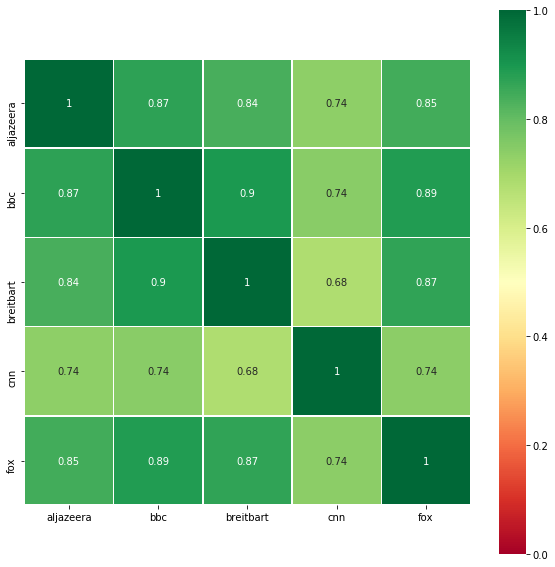

In [16]:
# Plot heatmap
plt.figure(figsize = (10,10))
sns.heatmap(csmdf2,cmap="RdYlGn",vmin=0,vmax=1,linewidths=.5,annot=True,square=True)
plt.show()

In [17]:
# Reshape cosine similarity scores from wide to long
csmdf2_sorted=csmdf2.reset_index().melt(id_vars="index",var_name='news_site', value_name='cosine_similarity')
csmdf2_sorted=csmdf2_sorted.sort_values(by="cosine_similarity").drop_duplicates(subset="cosine_similarity")
csmdf2_sorted=csmdf2_sorted[csmdf2_sorted["cosine_similarity"] != 1]
csmdf2_sorted

,index,news_site,cosine_similarity
17,breitbart,cnn,0.6805
3,cnn,aljazeera,0.7355
23,cnn,fox,0.7388
16,bbc,cnn,0.7440
10,aljazeera,breitbart,0.8397
20,aljazeera,fox,0.8454
22,breitbart,fox,0.8674
5,aljazeera,bbc,0.8711
21,bbc,fox,0.8878
11,bbc,breitbart,0.8982


As expected, using no stopwords at all led to an increase in similarity scores across all news outlet pairs. The change is easily noticeable in the heatmap, wherein all boxes moved towards the green spectrum.

However, while the increase in similarity scores was universal, the magnitude of the increase varied across the different news outlet pairs. This led to a different ranking, where the highest similarity can now be noted between BBC and Breitbart, followed closely by BBC and Fox. This is in contrast to the previous result where Aljazeera and Fox possessed the highest similarity, followed closely by Aljazeera and BBC.

While Breitbart and CNN still possessed the greatest dissimilarity, the gap between their similarity score and the similarity scores of all the other pairs is not as pronounced as the results we obtaiend from our original model where stopwords were removed.

These results highlight the importance of taking account of stopwords, as the picture we generate of the similarities between different texts have a high risk of being adversely distorted by not doing so.

##### Sensitivity Analysis: Using a smaller set of stopwords

In [18]:
# Save stopwords from nltk.corpus
stopwords2 = sw.words('english')

In [19]:
# Compare the lengths of the original and new lists of stopwords
len(stopwords)

728

In [20]:
len(stopwords2)

179

In terms of number, the original set of stopwords is much more extensive than this set of stopwords that we imported from the Python nltk package.

In [21]:
# Generate document term matrix
dtm3 = gen_DTM([article for article in articles["Content"]],stopwords2) 
dtm3.index = articles.index
dtm3

,$50bn,'where,-,1,11,12,15,15-member,18,1:08,...,working,world,worse,would,writer,yalova,yelova,yet,£385bn,—
aljazeera,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
bbc,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0
breitbart,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
cnn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
fox,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,3.0


In [22]:
# Generate cosine similarity matrix
csmdf3 = csm(dtm3)
csmdf3

,aljazeera,bbc,breitbart,cnn,fox
aljazeera,1.0000,0.6457,0.5735,0.5100,0.6607
bbc,0.6457,1.0000,0.5806,0.4784,0.6126
breitbart,0.5735,0.5806,1.0000,0.3537,0.5426
cnn,0.5100,0.4784,0.3537,1.0000,0.4960
fox,0.6607,0.6126,0.5426,0.4960,1.0000


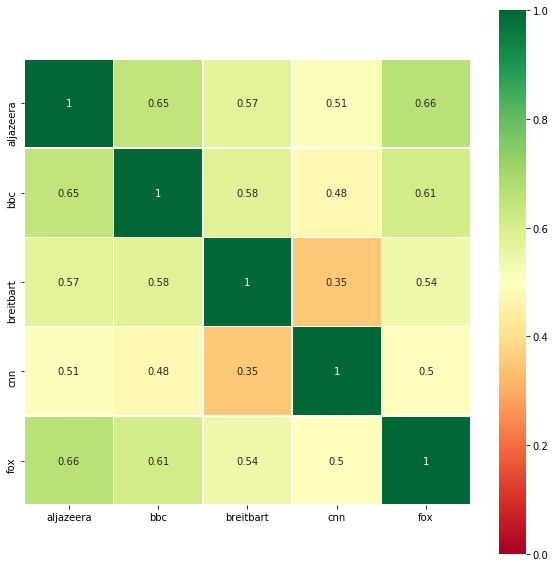

In [23]:
# Plot heatmap
plt.figure(figsize = (10,10))
sns.heatmap(csmdf3,cmap="RdYlGn",vmin=0,vmax=1,linewidths=.5,annot=True,square=True)
plt.show()

In [24]:
# Reshape cosine similarity scores from wide to long
csmdf3_sorted=csmdf3.reset_index().melt(id_vars="index",var_name='news_site', value_name='cosine_similarity')
csmdf3_sorted=csmdf3_sorted.sort_values(by="cosine_similarity").drop_duplicates(subset="cosine_similarity")
csmdf3_sorted=csmdf3_sorted[csmdf3_sorted["cosine_similarity"] != 1]
csmdf3_sorted

,index,news_site,cosine_similarity
17,breitbart,cnn,0.3537
16,bbc,cnn,0.4784
19,fox,cnn,0.4960
15,aljazeera,cnn,0.5100
22,breitbart,fox,0.5426
2,breitbart,aljazeera,0.5735
7,breitbart,bbc,0.5806
21,bbc,fox,0.6126
5,aljazeera,bbc,0.6457
20,aljazeera,fox,0.6607


Interestingly, decreasing the number of stopwords led to lower cosine similarity scores across the board. I speculate that this may be the case because the news outlets vary in their usage of what we previously considered as stopwords. As this is a cursory assessment, a deeper look into the differences of our two sets of stopwords may be warranted to properly understand the cause of the difference.

Nonetheless, the similarity rankings and the relative magnitudes of the similarity scores are still mostly the same as the initial results that we obtained. Breitbart and CNN still possess the lowest similarity among the group, and evidently far from the next pair at that. Likewise, Aljazeera and Fox possess the highest similarity, followed closely by Aljazeera and BBC. The rest of the rankings are the same, except for a minor switch between the Breitbart-BBC and Breitbart-Aljazeera pairs. Their scores were also previously close to each other.

That the results we obtained are mostly the same could be an indication of the robustness of our cosine similarity matrix.